<a href="https://colab.research.google.com/github/SoudruhRomanCZ/KRIVANEK-240642-MLF/blob/main/Project/Classification_5G_BTS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJEKT**

#0. Import needed libraries

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. Data preprocessing
## 1.1 Importing data




In [20]:
# Nastavení cesty k souborům na google drive
#ve složce jsou 2 .csv soubory a 2 složky s .npy soubory
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/MPA-MLF-Project_data'

# Načtení .csv souborů
label_train = pd.read_csv(os.path.join(data_path, 'label_train.csv'))
test_format = pd.read_csv(os.path.join(data_path, 'test_format.csv'))

# Načtení .npy souborů pro testování
train_data = []
for i in range(1491):
    file_path = os.path.join(data_path, 'Train', f'{i}.npy')
    if os.path.exists(file_path):
        data = np.load(file_path)
        train_data.append(data)

# Převedení listu do array
train_data = np.array(train_data)

# Načtení .npy souborů pro ověření přesnosti trénování
test_data = []
for i in range(120):
    file_path = os.path.join(data_path, 'Test', f'{i}.npy')
    if os.path.exists(file_path):
        data = np.load(file_path)
        test_data.append(data)

# Převedení listu do array
test_data = np.array(test_data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Zobrazení tvaru načtených dat
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')
print(f'Train label shape: {label_train.shape}')
print(f'Test format shape: {test_format.shape}')

Train data shape: (1491, 72, 48)
Test data shape: (120, 72, 48)
Train label shape: (1491, 2)
Test format shape: (120, 2)


##1.2 Preprocesing data

In [9]:
# === Nejprve rozděl originální data ===
y_label = label_train["target"].values
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    train_data,
    y_label,
    test_size=0.2,
    random_state=42,
    stratify=y_label  # zachová poměr tříd
)

# === Potom proveď augmentaci pouze na trénovací množině ===
awgn_std=3.0
# Rozdělíme data do tří tříd
bts0 = X_train_orig[y_train_orig == 0]
bts1 = X_train_orig[y_train_orig == 1]
bts2 = X_train_orig[y_train_orig == 2]

# Zjistíme počet vzorků pro každou třídu
count0, count1, count2 = bts0.shape[0], bts1.shape[0], bts2.shape[0]
target = max(count0, count1, count2)  # Cílový počet vzorků pro každou třídu

# Funkce pro syntézu vzorků
def synthesize(data, target_count):
    n = data.shape[0]
    diff = target_count - n  # Kolik syntetických vzorků doplníme
    synthetic = []

    for _ in range(diff):
        idx = np.random.randint(n)  # Náhodný výběr existujícího vzorku
        sample = data[idx]
        noise = np.random.normal(0, awgn_std, size=sample.shape)
        synthetic.append(sample + noise)
    if synthetic:
        synthetic = np.array(synthetic)
        return np.concatenate([data, synthetic], axis=0)
    else:
        return data

# Augmentace pro každou třídu
new_bts0 = synthesize(bts0, target)
new_bts1 = synthesize(bts1, target)
new_bts2 = synthesize(bts2, target)

# Spojíme všechna data dohromady a vytvoříme příslušné štítky
X_train_augmented = np.concatenate([new_bts0, new_bts1, new_bts2], axis=0)
y_train_augmented = np.concatenate(
    [np.full(new_bts0.shape[0], 0, dtype=y_train_orig.dtype),
     np.full(new_bts1.shape[0], 1, dtype=y_train_orig.dtype),
     np.full(new_bts2.shape[0], 2, dtype=y_train_orig.dtype)
    ], axis=0)

# === Dále pokračuj standardním škálováním ===
X_train_reshaped = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train_augmented.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# === Přidání kanálové dimenze pro CNN ===
X_train_final = X_train_scaled[..., np.newaxis]
X_test_final = X_test_scaled[..., np.newaxis]

# === One-hot encoding štítků ===
y_train_encoded = to_categorical(y_train_augmented, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)


#2. Model Selection and Implementation

In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(72, 48, 1), padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 72, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,539,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,539,779 (13.50 MB)

 Trainable params: 3,539,779 (13.50 MB)

 Non-trainable params: 0 (0.00 B)

#3. Model Training

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_final, y_train_encoded,
                    validation_data=(X_test_final, y_test_encoded),
                    epochs=20,
                    batch_size=32,
                    callbacks=[early_stop]
                    )

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8463 - loss: 0.3609 - val_accuracy: 0.9967 - val_loss: 0.0200
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9970 - loss: 0.0205 - val_accuracy: 0.9933 - val_loss: 0.0184
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9986 - loss: 0.0089 - val_accuracy: 0.9933 - val_loss: 0.0130
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9933 - val_loss: 0.0129
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9967 - val_loss: 0.0098
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9967 - val_loss: 0.0091
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9967 - val_loss: 0.0091
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 8.5756e-04 - val_accuracy: 0.9933 - val_

#4. Model Evaluation

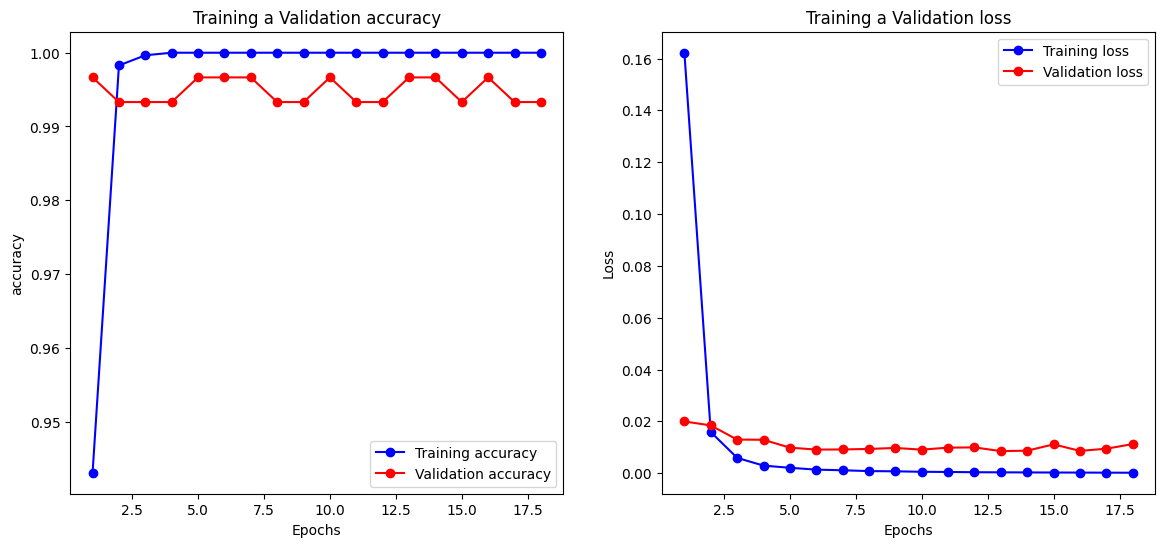

In [12]:
# Získání metrik z objektu history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Počet epoch
epochs = range(1, len(acc) + 1)

# Vykreslení přesnosti
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training a Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# Vykreslení ztráty
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training a Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#5. Conclusion



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


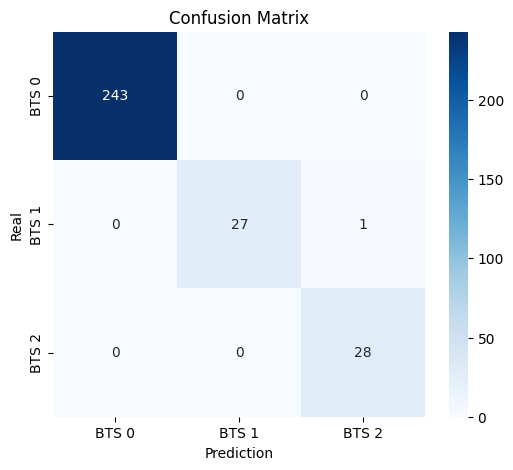

In [17]:
# Predikce pro validační data
y_pred = model.predict(X_test_final)

# Převedeme predikce i ground-truth zpět na třídy (0, 1, 2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Vytvoření matice záměn
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Vykreslení
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['BTS 0', 'BTS 1', 'BTS 2'],
            yticklabels=['BTS 0', 'BTS 1', 'BTS 2'])
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

#6. Saving data

In [16]:
# === Příprava testovacích dat ===
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)  # (120, 3456)
test_data_scaled = scaler.transform(test_data_reshaped)         # škálování jako tréninková data
test_data_scaled = test_data_scaled.reshape(test_data.shape)    # zpět na (120, 72, 48)
test_data_final = test_data_scaled[..., np.newaxis]             # přidání kanálu: (120, 72, 48, 1)
print(test_data_final.shape)  # ověř: (120, 72, 48, 1)
# === Kontrola modelu na testovacích datech ===
pred = model.predict(test_data_final)
# === Uložení predikce modelu do csv pro Kaggle ===
array_to_save = np.vstack((np.arange(0, 119 + 1), np.argmax(pred, axis=1)))
np.savetxt("/content/drive/MyDrive/MPA-MLF-Project_data/Evaluated_test_data.csv", array_to_save.transpose(), "%d", ",", header="ID,target", comments="")

(120, 72, 48, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
